<a href="https://colab.research.google.com/github/Geu-Pro2023/Wildlife_Chatbot/blob/main/Wildlife_Domain_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **WildGuard Conservation Chatbot**

### **Import Libaries**

In [50]:
# Import all required libraries
import pandas as pd
import numpy as np
import re
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from transformers import TextDataset, DataCollatorForLanguageModeling
from datasets import load_metric
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gradio as gr
import transformers
from tqdm import tqdm
import os
from google.colab import files

In [33]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download ('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [21]:
# Initialize text processing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

## **Data Loading**

In [22]:
print("Loading and exploring dataset...")
df = pd.read_csv('/content/drive/MyDrive/WildGuard_Chatbot/wildGuard_dataset.csv')


Loading and exploring dataset...


In [73]:
# Display the first few rows of dataset
df.head(20)

,Catergory,Question,Answer,cleaned_question,cleaned_answer,normalized_question
0,greetings,Hi,Hello! How can I assist you with wildlife cons...,hi,Hello! How can I assist you with wildlife cons...,hi
1,greetings,Good morning,Good morning! Ready to explore the world of wi...,good morning,Good morning! Ready to explore the world of wi...,good morning
2,greetings,Good evening,Good evening! Curious about animals or conserv...,good evening,Good evening! Curious about animals or conserv...,good evening
3,greetings,Howdy,Hey there! Need help with anything related to ...,howdy,Hey there! Need help with anything related to ...,howdy
4,greetings,Greetings,Greetings! What would you like to learn about ...,greeting,Greetings! What would you like to learn about ...,greetings
5,greetings,Hello,Hi there! How can I support your conservation ...,hello,Hi there! How can I support your conservation ...,hello
6,greetings,Hey,Hey! Got questions about endangered species or...,hey,Hey! Got questions about endangered species or...,hey
7,greetings,Hi,Hi! What would you like to know about protecti...,hi,Hi! What would you like to know about protecti...,hi
8,greetings,Good morning,Good morning! How can I help you make a differ...,good morning,Good morning! How can I help you make a differ...,good morning
9,greetings,Howdy,Howdy! Interested in wildlife facts or volunte...,howdy,Howdy! Interested in wildlife facts or volunte...,howdy


## **Data Exploration**

In [36]:
# Dataset analysis
print("Loading dataset...")

print("\nDataset Overview:")
print(f"Total samples: {len(df)}")
print("\nSample distribution by Catergory:")
print(df['Catergory'].value_counts())

Loading dataset...

Dataset Overview:
Total samples: 329

Sample distribution by Catergory:
Catergory
volunteering               35
laws_policies              35
habitat_protection         35
greetings                  24
wildlife_threats           20
fun_facts                  20
technology                 20
organizations              20
animal_behavior            20
education                  20
eco_friendly_activities    20
myths_facts                20
emergencies                20
climate_change             20
Name: count, dtype: int64


In [35]:
# Sample data
print("\nSample questions:")
print(df['Question'].sample(5).values)


Sample questions:
['What is hibernation?' 'Is hunting allowed in reserves?'
 'How can I volunteer to help wildlife?' 'Why are forests important?'
 'Howdy']


## **Data Preprocessing**

In [37]:
def download_nltk_resources():
    resources = {
        'punkt': ['punkt', 'punkt_tab'],
        'wordnet': ['wordnet'],
        'stopwords': ['stopwords'],
        'omw-1.4': ['omw-1.4']
    }

    for resource, packages in resources.items():
        try:
            for package in packages:
                nltk.download(package, quiet=True)
        except:
            print(f"Failed to download {resource}, trying again...")
            nltk.download(resource, quiet=True)

download_nltk_resources()

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Comprehensive text cleaning"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Tokenize with more robust error handling
    max_retries = 2
    for attempt in range(max_retries):
        try:
            tokens = word_tokenize(text)
            break
        except LookupError as e:
            if attempt == max_retries - 1:
                return ""  # Return empty string if tokenization fails after retries
            print(f"Tokenization failed, downloading punkt resources... Attempt {attempt + 1}")
            nltk.download('punkt', quiet=True)
            nltk.download('punkt_tab', quiet=True)

    # Lemmatize with error handling
    try:
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    except LookupError:
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(tokens)

# Apply cleaning with progress bar
tqdm.pandas()

print("Cleaning questions...")
df['cleaned_question'] = df['Question'].progress_apply(clean_text)

print("Cleaning answers...")
df['cleaned_answer'] = df['Answer'].progress_apply(clean_text)

# Save cleaned data
df.to_csv('cleaned_wildGuard_dataset.csv', index=False)
print("Cleaned data saved successfully!")

Cleaning questions...


100%|██████████| 329/329 [00:04<00:00, 73.40it/s]


Cleaning answers...


100%|██████████| 329/329 [00:00<00:00, 4962.89it/s]

Cleaned data saved successfully!


## **Data Visualization**

Visualizing data...


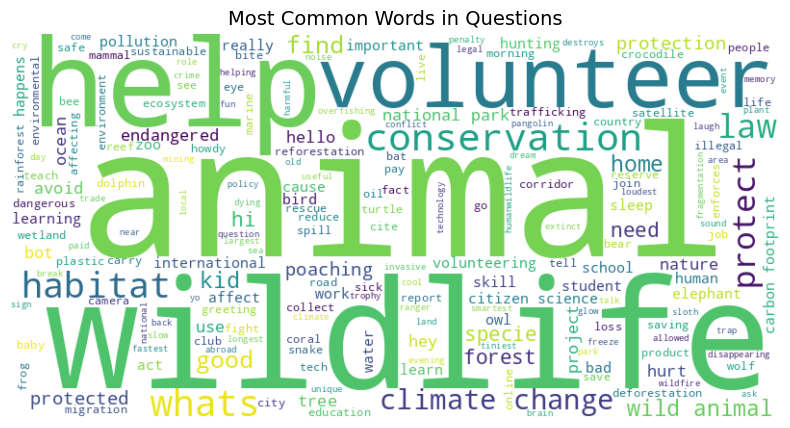

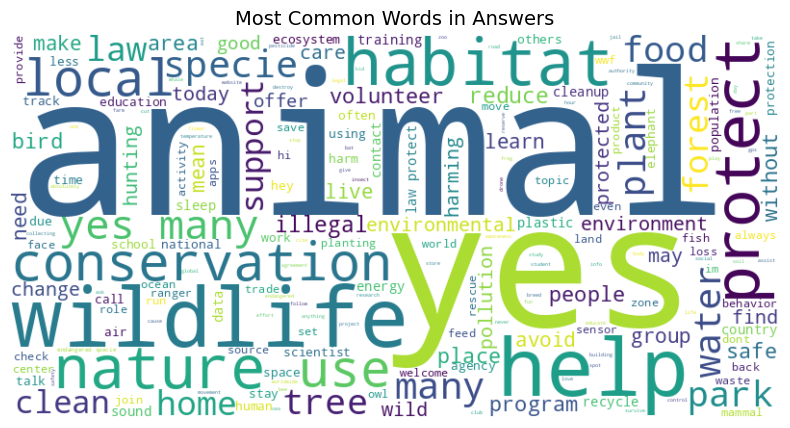

In [45]:
# Word cloud for questions and answers
def generate_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

print("Visualizing data...")

generate_wordcloud(df['cleaned_question'], "Most Common Words in Questions")
generate_wordcloud(df['cleaned_answer'], "Most Common Words in Answers")

## **Downloading GPT-2 from Hugging Face**

In [46]:
# Initialize GPT-2 tokenizer and model
print("Downloading GPT-2 from Hugging Face...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Add special tokens for conversation
special_tokens_dict = {'additional_special_tokens': ['User:', 'Bot:']}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

print("\nModel successfully downloaded from Hugging Face!")
print(f"Model name: {model.name_or_path}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



Model successfully downloaded from Hugging Face!
Model name: gpt2
Vocabulary size: 50257


## **Dataset Preparation for Fine-Tuning**

In [47]:
# Format as conversational pairs
conversations = [f"User: {row['cleaned_question']}\nBot: {row['cleaned_answer']}\n"
                for _, row in df.iterrows()]

# Split into train and validation
train_conv, val_conv = train_test_split(conversations, test_size=0.2, random_state=42)

# Save to files
with open('train_conversations.txt', 'w') as f:
    f.write('\n'.join(train_conv))

with open('val_conversations.txt', 'w') as f:
    f.write('\n'.join(val_conv))

# Create dataset objects
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="train_conversations.txt",
    block_size=128
)

val_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="val_conversations.txt",
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


## **Model Fine-Tuning**

In [56]:
from transformers import TrainingArguments, Trainer

# Training configuration
training_args = TrainingArguments(
    output_dir="./gpt2-wildlife",  # Save location
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    eval_steps=500,               # How often to evaluate
    save_steps=1000,              # How often to save
    warmup_steps=500,
    save_total_limit=2,
    report_to="none"              # Disable external logging
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

# Run training
print("Training starting...")
trainer.train()
trainer.save_model("./gpt2-final")
print("Training complete")

Training starting...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Training complete


## **Model Evaluation**


Evaluation Results:
                                       question  bleu    rougeL
0       How does climate change affect animals?   0.0  0.021053
1          Can animals adapt to climate change?   0.0  0.043478
2  Can climate change cause species extinction?   0.0  0.020833
3                          Hi, can you help me?   0.0  0.042553


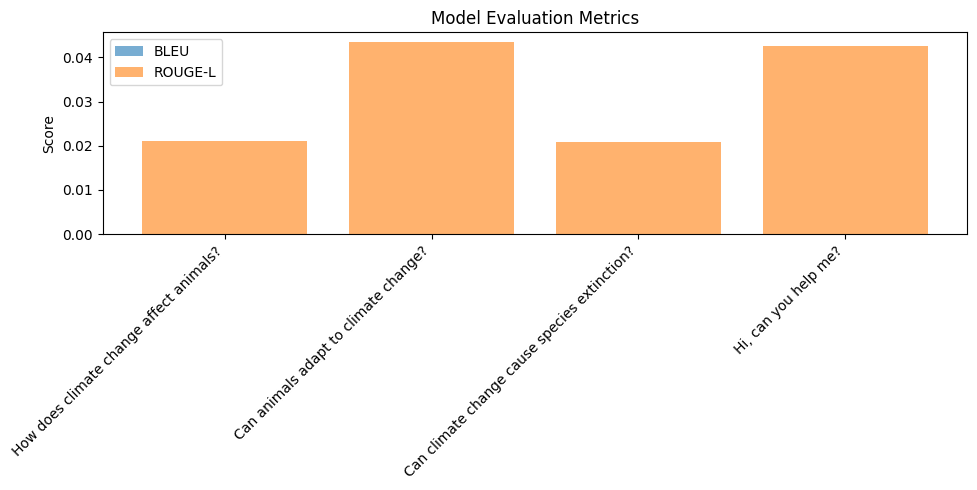

In [74]:
from datasets import load_metric
import matplotlib.pyplot as plt

# Load evaluation metrics
bleu = load_metric("bleu")
rouge = load_metric("rouge")

# Define raw test questions
test_questions = [
    "How does climate change affect animals?",
    "Can animals adapt to climate change?",
    "Can climate change cause species extinction?",
    "Hi, can you help me?"
]


# Clean test questions to match the cleaned dataset format
cleaned_test_questions = [clean_text(q) for q in test_questions]

# Evaluation function
def evaluate_model():
    results = []
    for raw_q, cleaned_q in zip(test_questions, cleaned_test_questions):
        input_text = f"User: {raw_q}\nBot:"
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        attention_mask = input_ids.ne(tokenizer.pad_token_id)

        # Generate response
        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=100,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )

        pred_answer = tokenizer.decode(output[0], skip_special_tokens=True).replace(input_text, "").strip()

        # Match with cleaned question
        ref_answers = df[df['cleaned_question'] == cleaned_q]['cleaned_answer'].tolist()

        if ref_answers:
            bleu_score = bleu.compute(
                predictions=[pred_answer.split()],
                references=[[ref.split() for ref in ref_answers]]
            )['bleu']

            rouge_score = rouge.compute(
                predictions=[pred_answer],
                references=[ref_answers[0]]
            )

            results.append({
                'question': raw_q,
                'predicted': pred_answer,
                'reference': ref_answers[0],
                'bleu': bleu_score,
                'rougeL': rouge_score['rougeL'].mid.fmeasure
            })
        else:
            print(f"No reference found for: {raw_q} → {cleaned_q}")

    return pd.DataFrame(results)

# Run evaluation
eval_results = evaluate_model()

# Display and plot results
if not eval_results.empty:
    print("\nEvaluation Results:")
    print(eval_results[['question', 'bleu', 'rougeL']])

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(eval_results['question'], eval_results['bleu'], alpha=0.6, label='BLEU')
    plt.bar(eval_results['question'], eval_results['rougeL'], alpha=0.6, label='ROUGE-L')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No evaluation results. Your cleaned test questions do not exist in the dataset.")


In [86]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=24, training_loss=7.697804133097331, metrics={'train_runtime': 227.4352, 'train_samples_per_second': 0.383, 'train_steps_per_second': 0.106, 'total_flos': 5683101696000.0, 'train_loss': 7.697804133097331, 'epoch': 3.0})

In [91]:
trainer.state.log_history

[{'train_runtime': 227.4352,
  'train_samples_per_second': 0.383,
  'train_steps_per_second': 0.106,
  'total_flos': 5683101696000.0,
  'train_loss': 7.697804133097331,
  'epoch': 3.0,
  'step': 24}]

In [92]:
import pandas as pd

logs_df = pd.DataFrame(trainer.state.log_history)
logs_df = logs_df.dropna(axis=1, how='all')  # Remove empty columns
display(logs_df.tail())


,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch,step
0,227.4352,0.383,0.106,5.683102e+12,7.697804,3.0,24


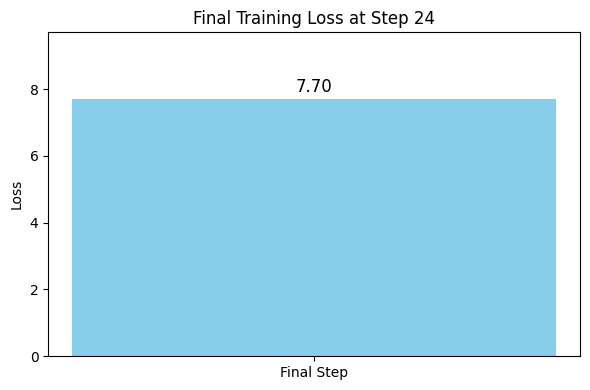

In [93]:
import matplotlib.pyplot as plt

# Extract final training loss and step
final_step = 24
final_loss = 7.6978  # or float from your output

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Final Step'], [final_loss], color='skyblue')
plt.ylabel('Loss')
plt.title(f"Final Training Loss at Step {final_step}")
plt.ylim(0, final_loss + 2)
plt.text(0, final_loss + 0.2, f"{final_loss:.2f}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

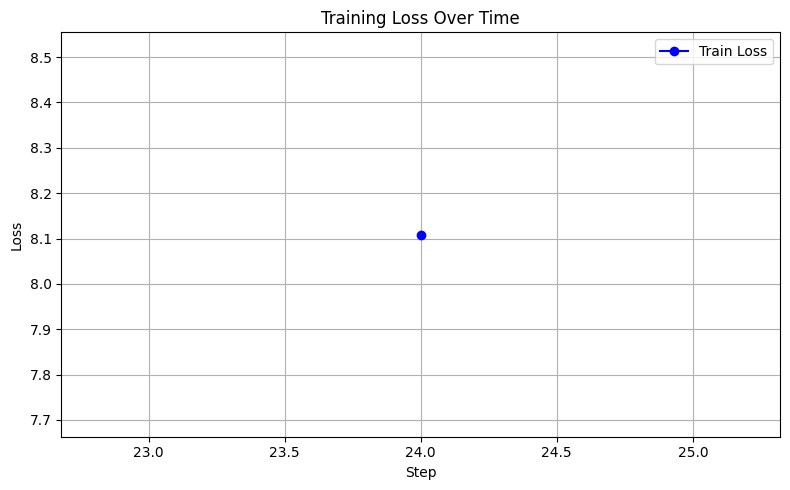

In [85]:
# Plot train loss over steps
if 'train_loss' in logs_df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(logs_df['step'], logs_df['train_loss'], marker='o', label='Train Loss', color='blue')
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No 'train_loss' found in log history.")


## **Model Architecture**

In [ ]:
# Model Architecture
print("\nBuilding model...")
model = Sequential()
model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y_train[0]), activation='softmax'))

# Learning rate schedule for better convergence
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile model with multiple metrics
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

print("\nModel Summary:")
model.summary()


Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,598 (420.30 KB)

 Trainable params: 107,598 (420.30 KB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [ ]:
# Model Training
print("\nTraining model...")
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=12,
                   validation_data=(X_val, y_val),
                   verbose=1)


Training model...
Epoch 1/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.8709 - Recall: 0.3651 - accuracy: 0.5706 - loss: 1.3675 - val_Precision: 0.9960 - val_Recall: 0.9910 - val_accuracy: 0.9938 - val_loss: 0.0631
Epoch 2/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.9819 - Recall: 0.9636 - accuracy: 0.9720 - loss: 0.1108 - val_Precision: 0.9961 - val_Recall: 0.9961 - val_accuracy: 0.9961 - val_loss: 0.0110
Epoch 3/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - Precision: 0.9899 - Recall: 0.9859 - accuracy: 0.9884 - loss: 0.0473 - val_Precision: 0.9961 - val_Recall: 0.9961 - val_accuracy: 0.9961 - val_loss: 0.0110
Epoch 4/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.9936 - Recall: 0.9919 - accuracy: 0.9928 - loss: 0.0307 - val_Precision: 0.9961 - val_Recall: 0.9961 - val_accuracy: 0.9961 - val_loss: 0.0111
Epoch 5/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - Precision: 0.9942 - Recall: 0.9930 - accuracy: 0.9937 - loss: 0.0255 - val_Precision: 0

## **Save Model**

In [ ]:
# Save Model
model.save('wildlife_chatbot_model.h5')
print("\nModel saved successfully!")


Model saved successfully!


## **Chatbot Interface**

In [ ]:
# Chatbot Interface
def predict_class(sentence):
    """Predict the intent class of a given sentence"""
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'Catergory': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    """Get appropriate response based on predicted Catergory"""
    if not intents_list:
        return "I'm not sure how to help with that. Could you rephrase your question?"
    tag = intents_list[0]['Catergory']
    for i in intents_json['Catergory']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "I don't understand. Could you try asking in a different way?"

In [ ]:
# First, let's modify the predict_class function to be more strict
def predict_class(text):
    embedding = get_bert_embedding(text)
    pred = model.predict(embedding)

    # Only consider predictions with >50% confidence
    results = [[i, r] for i, r in enumerate(pred[0]) if r > 0.5]

    if not results:  # If no confident predictions
        return None

    results.sort(key=lambda x: x[1], reverse=True)
    return [{"Catergory": classes[r[0]],
             "probability": str(r[1]),
             "pattern": text} for r in results]

# 2. Enhanced get_response function
def get_response(intents_list, intents_data):
    if not intents_list:
        return "I'm not sure about that wildlife topic. Could you be more specific?"

    best_match = intents_list[0]
    category = best_match['Catergory']
    user_input = best_match['pattern'].lower()

    # Find all possible responses for this category
    possible_responses = []
    for intent in intents_data['Catergory']:
        if category in intent['tags']:
            # Check if user input closely matches any pattern
            for pattern in intent['patterns']:
                if user_input in pattern.lower() or pattern.lower() in user_input:
                    return random.choice(intent['responses'])
            possible_responses.extend(intent['responses'])

    if possible_responses:
        return random.choice(possible_responses)
    return "I don't have information on that specific topic."

# 3. Updated Interactive Testing
print("\n🌿 Wildlife Conservation Expert (type 'quit' to exit)")

while True:
    message = input("\nYou: ").strip()
    if message.lower() in ['quit', 'exit']:
        print("🦉 Thank you for supporting wildlife conservation!")
        break

    ints = predict_class(message)
    response = get_response(ints, dict_)

    print(f"\nBot: {response}")
    if ints:
        print(f"Category: {ints[0]['Catergory']}")
        print(f"Confidence: {float(ints[0]['probability']):.0%}")

    # Show suggestions if confidence is low or no match
    if not ints or float(ints[0]['probability']) < 0.6:
        print("\nTry asking about:")
        print("- Animal habitats ('where do pandas live?')")
        print("- Conservation efforts ('how can I help tigers?')")
        print("- Volunteer opportunities ('can students volunteer?')")


🌿 Wildlife Conservation Expert (type 'quit' to exit)

You: hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Bot: Hello! How can I assist you with wildlife conservation today?
Category: greetings
Confidence: 100%

You: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Bot: Hi there! How can I support your conservation journey today?
Category: greetings
Confidence: 100%

You: Good morning?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Bot: Good morning! Ready to explore the world of wildlife?
Category: greetings
Confidence: 100%

You: Good evening
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Bot: Good evening! Curious about animals or conservation topics?
Category: greetings
Confidence: 100%

You: Hello bot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Bot: Hi there! How can I support your conservation journey today?
Category: greetings
Confidence: 100%

You: bot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Bot: Hello! I'm  your conservation guide‚ how can I help you?
Category: greetings
Confidence: 100%

You: Good day
1/1 

#**The End!**